In [1]:
import keras
import pandas as pd

import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from keras.applications import MobileNet
from keras.optimizers import Adam

from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


In [2]:
def getEmotionCode(x):
    part = x.split('_')
    if part[2] == 'SAD':
        return 0
    elif part[2] == 'ANG':
        return 1
    elif part[2] == 'DIS':
        return 2
    elif part[2] == 'FEA':
        return 3
    elif part[2] == 'HAP':
        return 4
    elif part[2] == 'NEU':
        return 5
    else:
        return 'Unknown'




IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



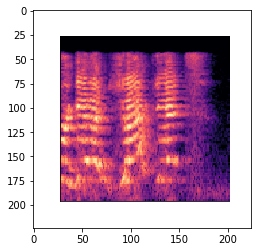

In [3]:
X_all = []
Y_all = []

image_folder_path = 'cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((224,224))
    spectrogram = np.array(spectrogram)
    X_all.append(spectrogram)
    Y_all.append(getEmotionCode(file_name))
    
print(X_all)
print(Y_all)
plt.imshow(X_all[0])


In [4]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=6)

print(X_all)
print(Y_all)

(3512, 224, 224, 3)
(3512,)
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, random_state = 123)


In [6]:
base_model = MobileNet(include_top=False, weights='imagenet', pooling='avg', alpha=.25, input_shape=(224,224,3), depth_multiplier=1, dropout=.2)


for layer in base_model.layers: # here we freeze the layers from mobilenet
    layer.trainable=False
    
x_top = base_model.output
x_dense = Dense(10, activation='relu')(x_top)
x_out = Dense(6, name='output', activation='softmax')(x_dense)
model = Model(base_model.input, x_out)
model.summary()

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

2113536/2108140 [==============================] - 18s 8us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 8)       216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 8)       32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 8)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 8)       72        
_____________________________________________________________

In [7]:
history = model.fit(X_train, Y_train, 
              epochs=10, 
              validation_data=(X_test, Y_test), 
              verbose=1, batch_size=32)


Train on 2634 samples, validate on 878 samples
Epoch 1/10
2634/2634 [==============================] - 56s 21ms/step - loss: 1.7800 - accuracy: 0.2251 - val_loss: 1.7767 - val_accuracy: 0.1788
Epoch 2/10
2634/2634 [==============================] - 53s 20ms/step - loss: 1.7288 - accuracy: 0.2585 - val_loss: 1.7750 - val_accuracy: 0.1617
Epoch 3/10
2634/2634 [==============================] - 56s 21ms/step - loss: 1.6930 - accuracy: 0.2680 - val_loss: 1.7456 - val_accuracy: 0.2005
Epoch 4/10
2634/2634 [==============================] - 58s 22ms/step - loss: 1.6698 - accuracy: 0.2733 - val_loss: 1.7301 - val_accuracy: 0.2323
Epoch 5/10
2634/2634 [==============================] - 54s 21ms/step - loss: 1.6502 - accuracy: 0.2809 - val_loss: 1.7291 - val_accuracy: 0.2289
Epoch 6/10
2634/2634 [==============================] - 53s 20ms/step - loss: 1.6329 - accuracy: 0.2775 - val_loss: 1.7207 - val_accuracy: 0.2358
Epoch 7/10
2634/2634 [==============================] - 50s 19ms/step - loss:

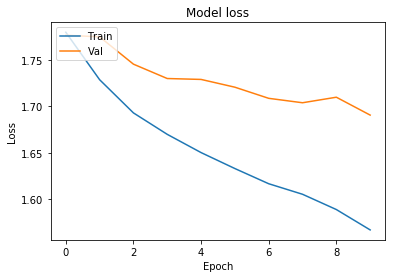

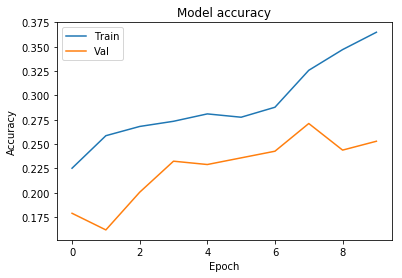

In [8]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Val'], loc='upper left') 
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [9]:
hist_df = pd.DataFrame(history.history) 

hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [11]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

model.save('mobile_net_trained.model') #Save the model

#mobile_net_model = tf.keras.models.load_model('mobile_net_trained.model') #Re load model
y_pred = model.predict(X_test)

#print(classification_report(Y_test, y_pred))